# Lab2 - TSP EA solution

In [154]:
from itertools import combinations
import pandas as pd
import numpy as np
import geopy.distance
import matplotlib.pyplot as plt
import random
from dataclasses import dataclass
from tqdm.auto import tqdm

In [155]:
CITIES = pd.read_csv('cities/china.csv', header=None, names=['name', 'lat', 'lon'])

POPULATION_SIZE = len(CITIES)*5
OFFSPRING_SIZE = int(POPULATION_SIZE*0.5)
MAX_GENERATIONS = 4000

# Reproducible random
rng = np.random.Generator(np.random.PCG64([POPULATION_SIZE, OFFSPRING_SIZE, MAX_GENERATIONS]))

In [156]:
# Save for each couple save -> ( distance, index of compared city )
DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)), dtype=tuple)
for c1, c2 in combinations(CITIES.itertuples(), 2):
    DIST_MATRIX[c1.Index, c2.Index] = (geopy.distance.geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km, c2.Index)
    DIST_MATRIX[c2.Index, c1.Index] = (geopy.distance.geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km, c1.Index)

## Helper Functions

In [157]:
def cost(path):
    circular_path = path + [path[0]]
    tot_dist = 0
    for i in range(len(circular_path)-1):
        tot_dist += DIST_MATRIX[circular_path[i],circular_path[i+1]][0]
    return tot_dist


In [158]:
def print_path(path):
    circular_path = path + [path[0]]
    print("Path:")
    for i in range(len(circular_path)-1):
        print(f"{CITIES.at[circular_path[i],'name']} -> {CITIES.at[circular_path[i+1],'name']} ({DIST_MATRIX[circular_path[i],circular_path[i+1]][0]:.2f}km)")

    print(f"\nNumber of steps: {len(circular_path)-1} , Total lenght: {cost(path):.2f} km")


In [159]:
def visualize_path(path):
    circular_path = path + [path[0]]
    x_coordinates = [CITIES.at[i,'lon'] for i in circular_path]
    y_coordinates = [CITIES.at[i,'lat'] for i in circular_path]

    plt.figure()
    plt.title("Path EA Resolution")
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.axis('equal')
    plt.plot(x_coordinates,y_coordinates,marker='o', linestyle='-', color='b')
    plt.show()

In [160]:
@dataclass
class Individual:
    genome: list
    fitness: float = None

In [161]:
def parent_selection(population):
    candidates = sorted(rng.choice(population,4), key=lambda e: e.fitness)
    
    return candidates[0], candidates[3]

In [162]:
def max_distance(path):
    circular_path = path + [path[0]]
    distances = np.zeros(len(CITIES),dtype=tuple)
    for i in range(0,len(circular_path)-1):
        distances[i] = (DIST_MATRIX[circular_path[i],circular_path[i+1]][0],DIST_MATRIX[circular_path[i],circular_path[i+1]][1])

    sorted_dist = sorted(distances, key= lambda x: x[0])[:len(CITIES)//5]

    return sorted_dist[rng.integers(0,len(CITIES)//5)][1]


In [163]:
def inversion_between(p1: Individual, p2: Individual):
    x=0
    while x < 0.5:
        longest_dist_p2 = max_distance(p2.genome)

        index_p1 = p1.genome.index(p2.genome[longest_dist_p2])
        seq_len = rng.integers(0,len(CITIES)+index_p1)
        seq_len = seq_len % len(CITIES)

        child_genome = p1.genome.copy()
        child_genome[index_p1:index_p1+seq_len] = p1.genome[index_p1:index_p1+seq_len][::-1]
        
        if cost(child_genome)<cost(p1.genome):
            break
        x=rng.random()

    return Individual(child_genome)

    

In [164]:
def mutation(p:Individual):
    child_genome = p.genome.copy()
    x = 0
    while x < 0.6:
        if rng.random()<0.2:
            # Try changing the place of max distance
            longest_dist = max_distance(child_genome)
            
            exchange_i = rng.integers(0,len(CITIES))
        
            temp = child_genome[longest_dist]
            child_genome[longest_dist] = child_genome[exchange_i]
            child_genome[exchange_i] = temp
        else:
            # Try swapping random sequences
            seq_len = rng.integers(1,len(CITIES)//4) 
            start_i = rng.integers(0,len(CITIES)-seq_len)

            seq = child_genome[start_i:start_i+seq_len]
            genome_no_seq = child_genome[:start_i] + child_genome[start_i+seq_len:]

            new_i = rng.integers(0,len(genome_no_seq))
            new_genome = genome_no_seq[:new_i] + seq + genome_no_seq[new_i:]

            child_genome = new_genome

        # if the cost is less return the child 
        if cost(child_genome)<cost(p.genome):
                break

        x = rng.random()
    return Individual(child_genome)

    

In [165]:
def compute_fast_min(start):
    # Search min algorithm
    visited = np.full(len(CITIES), False)
    curr_city_i = start
    visited[curr_city_i] = True
    path = list()
    path.append(curr_city_i)

    while not np.all(visited):

        # Find the city with minimum distance and take the correspondig index to make it the next city
        next_city_tup= np.min(DIST_MATRIX[curr_city_i,np.logical_not(visited)])
        curr_city_i = next_city_tup[1]

        path.append(curr_city_i)
        visited[curr_city_i] = True
    
    return path


# EA Resolution

In [166]:
cities_idx = [i for i in range(len(CITIES))]

population = [Individual(compute_fast_min(i)) for i in range(len(CITIES))]

for i in population:
    i.fitness = cost(i.genome)

for _ in tqdm(range(MAX_GENERATIONS)):
    offspring = list()

    for _ in range(OFFSPRING_SIZE):
        
        p1,p2 = parent_selection(population)
        
        if rng.random() <0.6:
            o = inversion_between(p1,p2)
        else:
            o = mutation(p1)

        offspring.append(o)

    for i in offspring:
        i.fitness = cost(i.genome)

    population.extend(offspring)
    population.sort(key=lambda i: i.fitness)
    population = population[:POPULATION_SIZE]


100%|██████████| 4000/4000 [8:56:18<00:00,  8.04s/it]  


Path:
Hengyang -> Qidong (51.17km)
Qidong -> Changning (59.18km)
Changning -> Leiyang (42.60km)
Leiyang -> Chenzhou (71.27km)
Chenzhou -> Zixing (41.42km)
Zixing -> Lecheng (91.72km)
Lecheng -> Shaoguan (44.25km)
Shaoguan -> Maba (13.29km)
Maba -> Yingde (59.22km)
Yingde -> Conghua (62.70km)
Conghua -> Zengcheng (43.29km)
Zengcheng -> Shilong (19.72km)
Shilong -> Dongguan (12.21km)
Dongguan -> Humen (22.23km)
Humen -> Shiqiao (32.03km)
Shiqiao -> Daliang (15.81km)
Daliang -> Xiaolan (7.32km)
Xiaolan -> Zhongshan (28.60km)
Zhongshan -> Jiangmen (28.32km)
Jiangmen -> Shaping (24.39km)
Shaping -> Foshan (33.14km)
Foshan -> Guangzhou (16.64km)
Guangzhou -> Huangpu (17.55km)
Huangpu -> Xinan (54.83km)
Xinan -> Sihui (29.06km)
Sihui -> Zhaoqing (40.92km)
Zhaoqing -> Gaoyao (2.13km)
Gaoyao -> Yunfu (44.09km)
Yunfu -> Luoding (51.30km)
Luoding -> Cenxi (59.07km)
Cenxi -> Wuzhou (68.29km)
Wuzhou -> Hezhou (106.27km)
Hezhou -> Lianzhou (93.17km)
Lianzhou -> Qingyuan (134.41km)
Qingyuan -> Luoyan

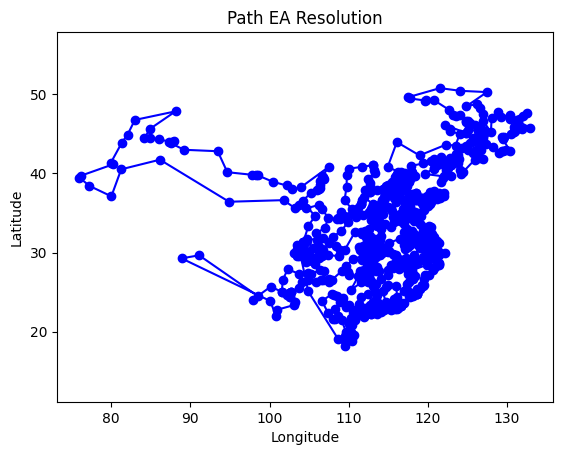

In [167]:
print_path(population[0].genome)
visualize_path(population[0].genome)